In [80]:
from matplotlib import pyplot as plt
from glob import glob 
import numpy as np

import keras
from keras import datasets
from keras import layers
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import pickle

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog

onehot = OneHotEncoder()
minMax = MinMaxScaler()

In [42]:
def print_metrics(y_test, y_pred, label=''):
    if len(y_test.shape) == 2:
        if y_test.shape[1] == 1:
            y_test = y_test[:, 0]
        elif y_test.shape[0] == 1:
            y_test = y_test[0]
        else:
            print("?")
    
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='macro')
    # Calculate metrics for each label, and find their unweighted mean. 
    
    print(f"{label}: Accuracy {acc:0.3f}\t F1 {f1:0.3f}")

# Image Classification

![](extra/types_tasks.png)

Source: https://www.kdnuggets.com/2018/09/object-detection-image-classification-yolo.html

# ImageNet

[The ImageNet Large Scale Visual Recognition Challenge (ILSVRC)](https://image-net.org/challenges/LSVRC/)
![](extra/imagenet.png)
Source: Deng, Jia, et al. "Imagenet: A large-scale hierarchical image database." 2009 IEEE conference on computer vision and pattern recognition. Ieee, 2009.

* 1000 Class List*

Localization, detaction, video ...

# CIFAR-10

#### The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

* data: a 10000x3072 numpy array of uint8s. 

* labels: a list of 10000 numbers in the range 0-9.


In [2]:
label2str = {0:"airplane", 1:"automobile", 2:"bird",
             3:"cat", 4:"deer", 5:"dog", 6:"frog",
             7:"horse", 8:"ship", 9:"truck"}

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

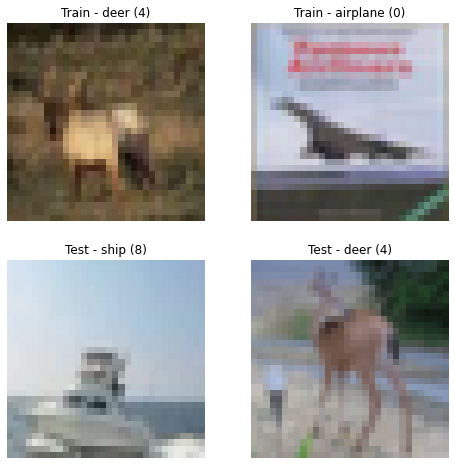

In [3]:
idx = 3
plt.figure(figsize=(8,8))

plt.subplot(221);plt.axis('off')
train_label = y_train[idx][0]
plt.title(f'Train - {label2str[train_label]} ({train_label})')
plt.imshow(x_train[idx])
           
plt.subplot(222);plt.axis('off')
test_label = y_test[idx][0]
plt.title(f'Train - {label2str[test_label]} ({test_label})')
plt.imshow(x_test[idx])

idx = 100
plt.subplot(223);plt.axis('off')
train_label = y_train[idx][0]
plt.title(f'Test - {label2str[train_label]} ({train_label})')
plt.imshow(x_train[idx])
           
plt.subplot(224);plt.axis('off')
test_label = y_test[idx][0]
plt.title(f'Test - {label2str[test_label]} ({test_label})')
plt.imshow(x_test[idx]);

In [4]:
y_train_hot = onehot.fit_transform(y_train).toarray()
y_test_hot  = onehot.transform(y_test).toarray()

x_train_norm = x_train/255
x_test_norm = x_test/255

x_train_row = x_train_norm.reshape(len(x_train_norm), -1)
x_test_row = x_test_norm.reshape(len(x_test_norm), -1)

# Random Choise

In [78]:
%%time
y_test_random = np.random.randint(0, 10, size=len(x_test))

CPU times: user 443 µs, sys: 0 ns, total: 443 µs
Wall time: 291 µs


In [79]:
print_metrics(y_test, y_test_random, 'Random')

Random: Accuracy 0.097	 F1 0.096


# Closest Element

In [5]:
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=6)

In [6]:
%%time
knn = knn.fit(x_train_row, y_train[:, 0])

CPU times: user 12.3 s, sys: 61.4 ms, total: 12.4 s
Wall time: 12.5 s


In [7]:
%%time
y_test_pred_knn = knn.predict(x_test_row)

CPU times: user 42min 20s, sys: 2.04 s, total: 42min 23s
Wall time: 7min 26s


In [16]:
y_test_pred_knn.shape, y_test.shape

((10000,), (10000, 1))

In [43]:
print_metrics(y_test, y_test_pred_knn, 'KNN')

KNN: Accuracy 0.354	 F1 0.349


# Features Extraction

In [88]:
x_train_hog = np.array([hog(src) for src in x_train])
x_test_hog = np.array([hog(src) for src in x_test])

In [55]:
%%time
knn_hog = knn.fit(x_train_hog, y_train[:, 0])

CPU times: user 1.48 s, sys: 7.87 ms, total: 1.49 s
Wall time: 1.49 s


In [56]:
%%time
y_test_pred_knn_hog = knn_hog.predict(x_test_hog)

CPU times: user 6min 14s, sys: 455 ms, total: 6min 15s
Wall time: 1min 5s


In [58]:
y_test_pred_knn_hog.shape, y_test.shape

((10000,), (10000, 1))

In [57]:
print_metrics(y_test, y_test_pred_knn_hog, 'KNN HOG')

KNN HOG: Accuracy 0.512	 F1 0.506


# Forest

In [81]:
forest = RandomForestClassifier(n_jobs=6)

In [82]:
%%time
forest = forest.fit(x_train_row, y_train[:, 0])

CPU times: user 3min 18s, sys: 796 ms, total: 3min 19s
Wall time: 35.5 s


In [90]:
%%time
y_test_pred_forest = forest.predict(x_test_row)

CPU times: user 686 ms, sys: 82.4 ms, total: 768 ms
Wall time: 308 ms


In [95]:
print_metrics(y_test, y_test_pred_forest, 'Forest')

Forest: Accuracy 0.468	 F1 0.464


# Forest + HOG

In [92]:
forest_hog = RandomForestClassifier(n_jobs=6)

In [93]:
%%time
forest_hog = forest_hog.fit(x_train_hog, y_train[:, 0])

CPU times: user 1min 23s, sys: 104 ms, total: 1min 23s
Wall time: 14.8 s


In [94]:
%%time
y_test_pred_forest_hog = forest_hog.predict(x_test_hog)

CPU times: user 275 ms, sys: 15.7 ms, total: 291 ms
Wall time: 106 ms


In [98]:
print_metrics(y_test, y_test_pred_forest_hog, 'Forest HOG')

Forest HOG: Accuracy 0.526	 F1 0.522


In [99]:
#Note: SVM

# Row

In [101]:
model_row = keras.Sequential()
model_row.add(layers.Dense(units=512, activation='relu'))
model_row.add(layers.Dense(units=120, activation='relu'))
model_row.add(layers.Dense(units=84, activation='relu'))
model_row.add(layers.Dense(units=10, activation = 'softmax'))
model_row.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

train_row = x_train_norm.reshape(len(x_train_norm), -1)
test_row = x_test_norm.reshape(len(x_test_norm), -1)
model_row.fit(train_row, y_train_hot, epochs=100, batch_size=256, validation_data=(test_row, y_test_hot))

Epoch 1/100
196/196 [==============================] - 2s 9ms/step - loss: 0.3391 - accuracy: 0.2142 - val_loss: 0.2769 - val_accuracy: 0.3559
Epoch 2/100
196/196 [==============================] - 2s 8ms/step - loss: 0.2727 - accuracy: 0.3656 - val_loss: 0.2684 - val_accuracy: 0.3567
Epoch 3/100
196/196 [==============================] - 2s 8ms/step - loss: 0.2594 - accuracy: 0.3919 - val_loss: 0.2581 - val_accuracy: 0.3961
Epoch 4/100
196/196 [==============================] - 2s 8ms/step - loss: 0.2496 - accuracy: 0.4182 - val_loss: 0.2445 - val_accuracy: 0.4324
Epoch 5/100
196/196 [==============================] - 2s 8ms/step - loss: 0.2417 - accuracy: 0.4449 - val_loss: 0.2398 - val_accuracy: 0.4516
Epoch 6/100
196/196 [==============================] - 2s 8ms/step - loss: 0.2367 - accuracy: 0.4538 - val_loss: 0.2327 - val_accuracy: 0.4655
Epoch 7/100
196/196 [==============================] - 2s 8ms/step - loss: 0.2318 - accuracy: 0.4702 - val_loss: 0.2301 - val_accuracy: 0.4757

In [105]:
model_row.

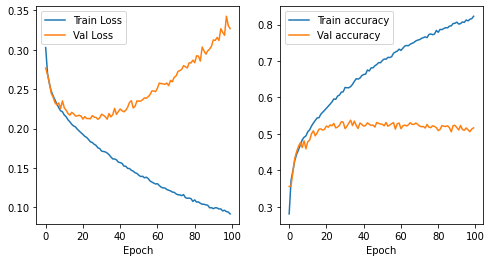

In [102]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(model_row.history.history['loss'], label="Train Loss")
plt.plot(model_row.history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(122)
plt.plot(model_row.history.history['accuracy'], label="Train accuracy")
plt.plot(model_row.history.history['val_accuracy'], label="Val accuracy")
plt.xlabel("Epoch")
plt.legend()

# As Image

In [106]:
model = keras.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=10, activation = 'softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train_norm, y_train_hot, epochs=200, batch_size=256, validation_data=(x_train_norm, y_train_hot))

Epoch 1/200
196/196 [==============================] - 6s 28ms/step - loss: 0.3777 - accuracy: 0.1622 - val_loss: 0.2633 - val_accuracy: 0.3735
Epoch 2/200
196/196 [==============================] - 5s 24ms/step - loss: 0.2585 - accuracy: 0.3877 - val_loss: 0.2447 - val_accuracy: 0.4250
Epoch 3/200
196/196 [==============================] - 5s 23ms/step - loss: 0.2439 - accuracy: 0.4267 - val_loss: 0.2369 - val_accuracy: 0.4474
Epoch 4/200
196/196 [==============================] - 5s 24ms/step - loss: 0.2348 - accuracy: 0.4536 - val_loss: 0.2290 - val_accuracy: 0.4718
Epoch 5/200
196/196 [==============================] - 4s 23ms/step - loss: 0.2293 - accuracy: 0.4673 - val_loss: 0.2231 - val_accuracy: 0.4882
Epoch 6/200
196/196 [==============================] - 4s 22ms/step - loss: 0.2221 - accuracy: 0.4904 - val_loss: 0.2153 - val_accuracy: 0.5096
Epoch 7/200
196/196 [==============================] - 5s 24ms/step - loss: 0.2151 - accuracy: 0.5118 - val_loss: 0.2082 - val_accuracy:

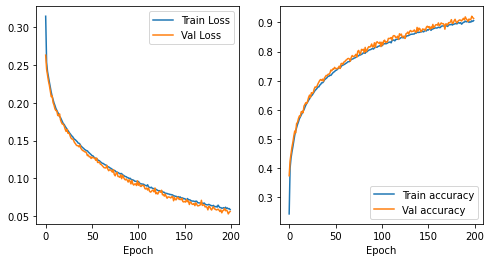

In [108]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(model.history.history['loss'], label="Train Loss")
plt.plot(model.history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(122)
plt.plot(model.history.history['accuracy'], label="Train accuracy")
plt.plot(model.history.history['val_accuracy'], label="Val accuracy")
plt.xlabel("Epoch")
plt.legend()

# Similarity 

In [109]:
sample_labels = [f"{idx} "+label2str[lab] for idx, lab in  enumerate(y_test[:,0])]
extractor     = keras.Model(inputs=model.inputs,
                            outputs=[layer.output for layer in model.layers])
features      = extractor(x_test_norm)
distances     = pairwise_distances(features[-2])

Text(0.5, 1.0, 'Distance')

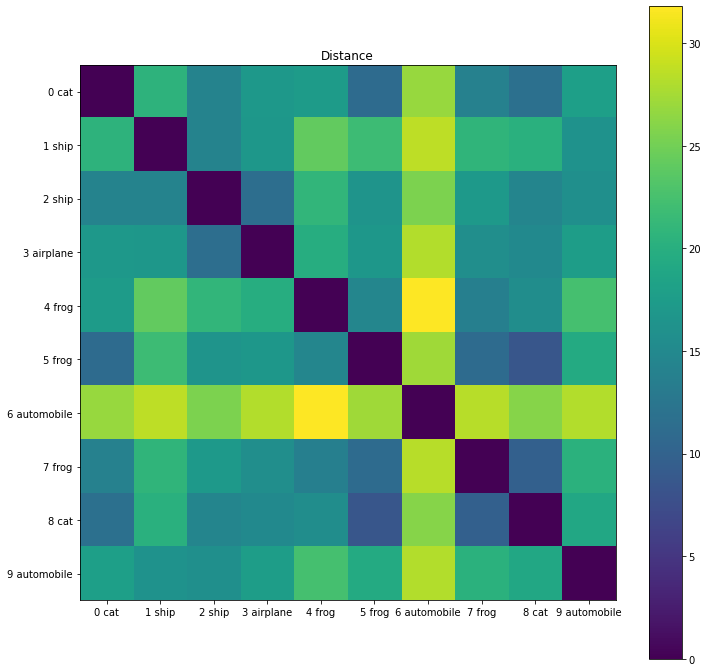

In [110]:
view_sample = 10
dist_norm = distances[:view_sample, :view_sample]
view_labels = sample_labels[:view_sample]
plt.figure(figsize=(12, 12))
plt.imshow(dist_norm)
plt.colorbar()
plt.yticks(range(view_sample), view_labels);
plt.xticks(range(view_sample), view_labels);
plt.title("Distance")

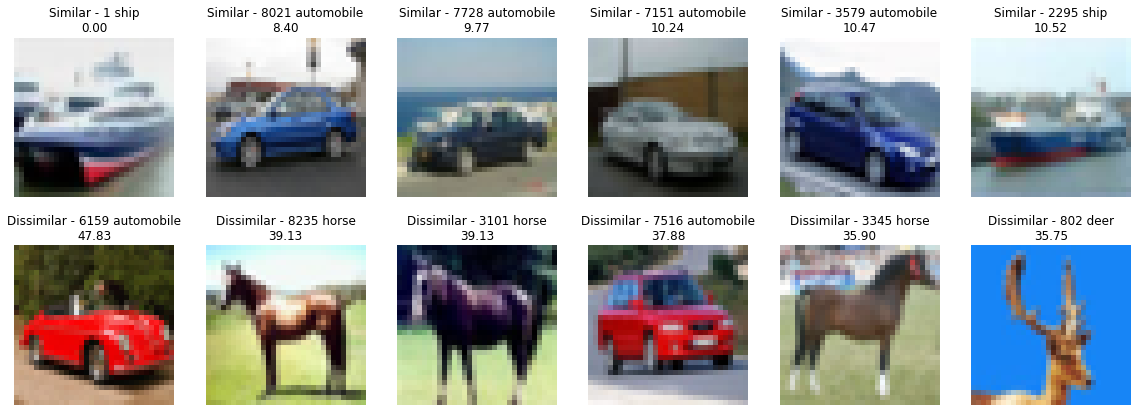

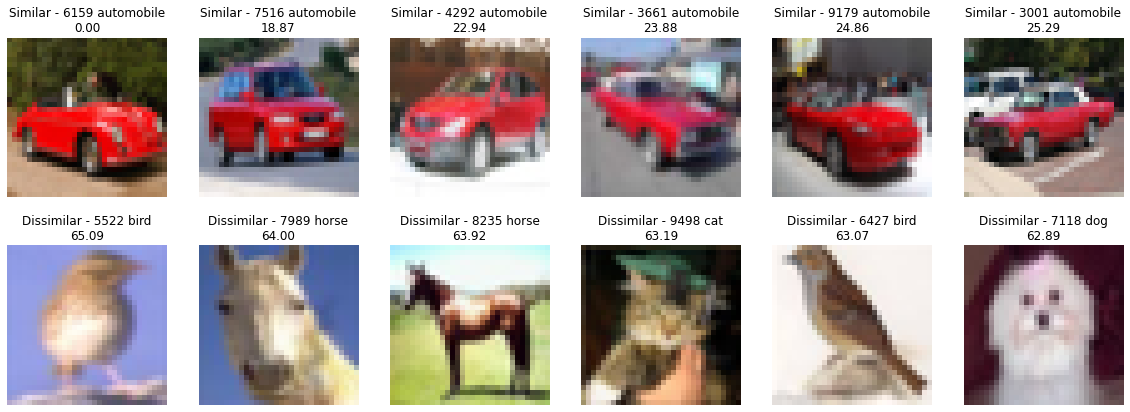

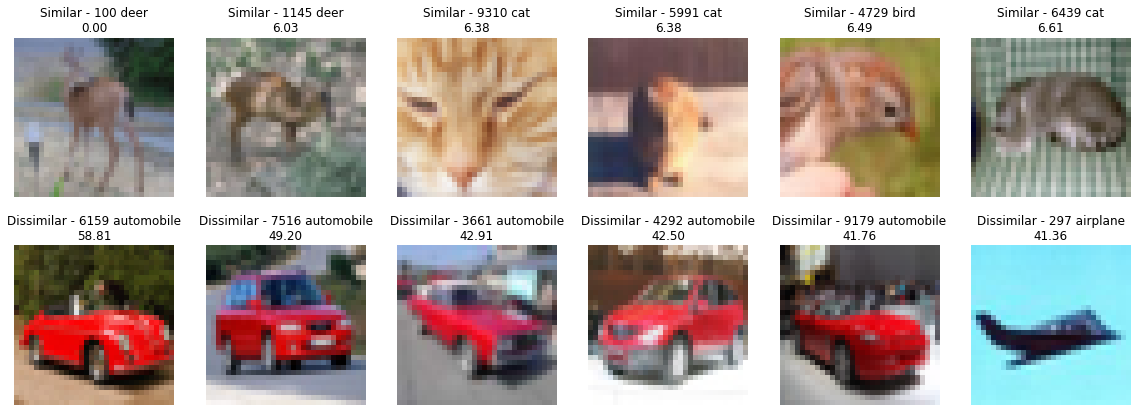

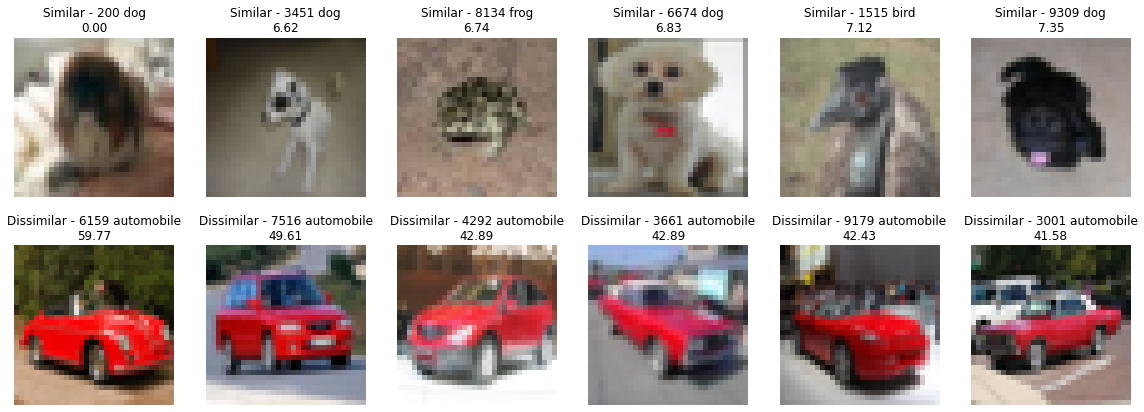

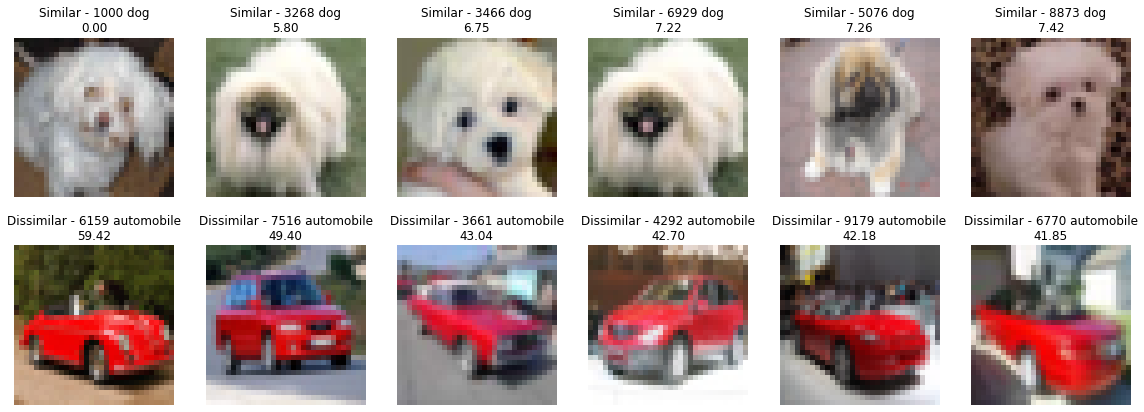

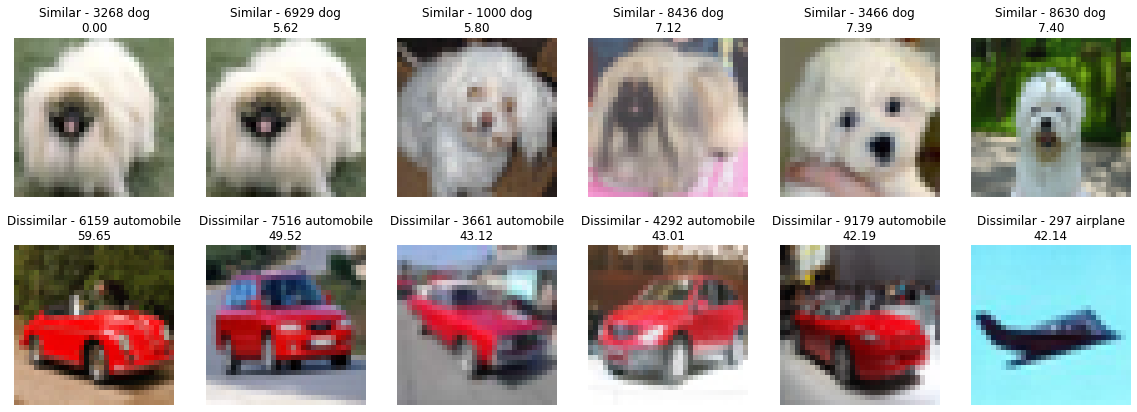

In [114]:
for id_sample in [1, 6159, 100, 200, 1000, 3268]:
    dist_argsort = distances[id_sample].argsort()
    similar = np.array(sample_labels)[dist_argsort]
    dist_ship = distances[id_sample][dist_argsort]

    len_data = len(x_test)
    plt.figure(figsize=(20, 7))
    for id_col in range(0, 6):
        plt.subplot(2,6, id_col+1)
        plt.title(f"Similar - {similar[id_col]}\n{dist_ship[id_col]:0.2f}")
        plt.imshow(x_test[dist_argsort[id_col]]);plt.axis('off')

    for id_col in range(0, 6):
        idx = len_data-id_col-1
        plt.subplot(2, 6, id_col+7)
        plt.title(f"Dissimilar - {similar[idx]}\n{dist_ship[idx]:0.2f}")
        plt.imshow(x_test[dist_argsort[idx]]);plt.axis('off')
